In [36]:
# Numerical
from jax.numpy import exp, sin, pi, mean, var    # Arithematic
from jax.numpy import arange, array # Array creation routines
from jax.lax import scan 
from jax import jit

# Miscellaneous
from functools import partial 
from itertools import repeat
from ticktack import load_presaved_model

# ODEINTs
from ode import odeint as BS3
from jax.experimental.ode import odeint as DP5
from time import process_time

# Visualisation
from pandas import DataFrame
from plotnine import *
import matplotlib.pyplot as plt

In [37]:
UNIT_FACTOR = 14.003242 / 6.022 * 5.11 * 31536. / 1.e5
PRODUCTION_RATE = 1.76

In [38]:

def odeint_linear(derivative, y0, timesteps, *args, **kwargs):
    step_size = timesteps[1] - timesteps[0]

    def step(y, time_value, step_size=None, derivative=None):
        next_time_value = y + derivative(y, time_value) * step_size
        return next_time_value, next_time_value

    step = partial(step, derivative=derivative, step_size=step_size)
    step = jit(step)

    _, y_values = scan(f=step, init=y0, xs=timesteps) 
    return y_values

In [39]:
def production(t, *args, steady_state=PRODUCTION_RATE):
    start, duration, phase, area = array(list(args)).reshape(-1)

    middle = start + duration / 2.
    height = area / duration
    gaussian = height * exp(- ((t - middle) / (duration / 2)) ** 16.)
    sinusoid = 0.18 * steady_state * sin(2 * pi / 11 * t + phase)
    production = gaussian + sinusoid + steady_state
    
    return UNIT_FACTOR * production

In [40]:
carbon_box_model = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
carbon_box_model.compile()

In [41]:
burn_in_time_out = arange(-225, 775)
burn_in_oversample = 1000
parameters = (774.86, 0.25, 0.8, 6.44)
growth_season = array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0])

In [42]:
# Running the burn-in
_, y_initial = carbon_box_model.run(burn_in_time_out, burn_in_oversample, \
    production, args=parameters, steady_state_production=PRODUCTION_RATE * UNIT_FACTOR)

In [43]:
time_out = arange(750, 800)

In [44]:
true_values, _ = carbon_box_model.run(time_out, burn_in_oversample, production,\
    y0=y_initial, args=parameters, steady_state_production=PRODUCTION_RATE * UNIT_FACTOR)

true_values = list(true_values[:, 1]) # Selecting the troposphere
time_values = [round(750 + i / burn_in_oversample, 3) for i in range(burn_in_oversample * 51)]

true_values = dict(zip(time_values, true_values))

In [45]:
odeint = {"Linear": odeint_linear, "BS3": BS3, "DP5": DP5}

In [46]:
odeint_oversample_resids = {
    "Solver": [],
    "Oversample": [],
    "Time (s)": [],
    "Time Var (s)": [],
    "Accuracy": []
}

In [47]:
for solver in odeint:
    for oversample in range(10, 200, 10):
        times = array([0 for _ in range(10)], dtype=float)
        for i in range(10):
            timer = process_time()
            solution, _ = carbon_box_model.run(time_out, oversample, \
                production, solver=odeint[solver], y0=y_initial, args=parameters, \
                steady_state_production=PRODUCTION_RATE * UNIT_FACTOR)
            timer = process_time() - timer
            times = times.at[i].set(timer) 

        # Calculating the residuals
        solution = solution[:, 1] # Selecting the troposphere values

        time_values = [round(750 + i / oversample, 3) for i in range(oversample * 51)]
        local_true_value = [true_values[time_value] for time_value in time_values]

        residuals = solution - array(local_true_value)
        accuracy = float(mean(residuals))

        del solution
        del local_true_value
        del residuals
        del time_values

        odeint_oversample_resids["Solver"].append(solver)
        odeint_oversample_resids["Oversample"].append(oversample)
        odeint_oversample_resids["Time (s)"].append(float(mean(times)))
        odeint_oversample_resids["Time Var (s)"].append(float(var(times)))
        odeint_oversample_resids["Accuracy"].append(abs(accuracy))

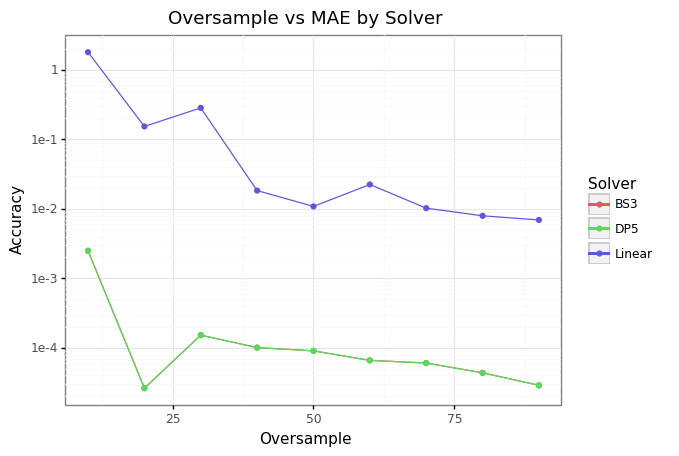

<ggplot: (8791790147624)>

In [ ]:
odeint_oversample_resids = DataFrame(odeint_oversample_resids)
(ggplot(odeint_oversample_resids, 
    aes(
        x="Oversample", 
        y="Accuracy", 
        color="Solver"
    ))
    + theme_bw()
    + geom_line()
    + geom_point()
    + scale_y_log10()
    + ggtitle("Oversample vs MAE by Solver"))

In [ ]:
odeint_oversample_resids["ymin"] = odeint_oversample_resids["Time (s)"] - \
     odeint_oversample_resids["Time Var (s)"]
odeint_oversample_resids["ymax"] = odeint_oversample_resids["Time (s)"] + \
     odeint_oversample_resids["Time Var (s)"]


/home/jordan/anaconda3/envs/kitkat/lib/python3.9/site-packages/pandas-1.4.0rc0-py3.9-linux-x86_64.egg/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10


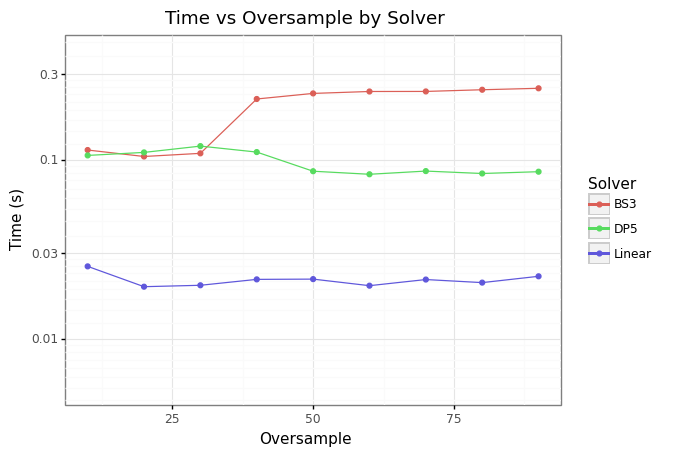

<ggplot: (8791789794783)>

In [ ]:
(ggplot(odeint_oversample_resids, 
    aes(
        x="Oversample", 
        y="Time (s)",
        ymin="ymin",
        ymax="ymax",
        color="Solver"
    ))
    + theme_bw()
    + geom_line()
    + geom_point()
    # + geom_errorbar()
    + scale_y_log10()
    + ggtitle("Time vs Oversample by Solver"))

Experimental analysis follows

In [ ]:
from jax.numpy import float64, zeros
from pandas import read_csv
from os import getcwd
from ticktack.fitting import SingleFitter

In [ ]:
fitting_object = SingleFitter(carbon_box_model, "Guttler14")

In [ ]:
def profile(func, args=[]) -> tuple:
    """
    Profiles the function, func, with the arguments, args, returning the speed and the variance of the speed.
    """
    time_sample = zeros(10)  # Storing the trials
    
    for i in range(10):
        timer = process_time()                          # starting a timer 
        func(*args).block_until_ready()                                     # Running the model 
        time_sample = time_sample.at[i].set(process_time() - timer)   # Stopping the timer and storing 

    return mean(time_sample), var(time_sample)

In [ ]:
results = {
    "module": [],
    "time": [],
    "type": []
}

odeints = {BS3 : "ode", DP5 : "jax", odeint_linear: "linear"} # For translation from string to module 

dataset = read_csv(f"{getcwd()}/datasets/775AD/NH/Miyake12_Cedar.csv") # Importing the miyake data

for namespace in odeints:# Iterating through the namespaces of odeint function 
    mean, variance = profile(carbon_box_model.run, [time_out, 100, \
                production, odeint[solver], y_initial, parameters, \
                PRODUCTION_RATE * UNIT_FACTOR]) )  # Profiling the speed
    results["module"].append(odeints[namespace])
    results["time"].append(float(mean) * 1000)
    results["type"].append("odeint")

    # Single variable function 
    loss = partial(loss_function, namespace.odeint, dataset, dydx, u0)

    # The gradients exist below 
    def gradient(p): 
        if namespaces[namespace] == "ode":
            return jacfwd(loss)(p)         # Calculating the gradient 
        else:
            return jacrev(loss)(p)

    mean, variance = profile(gradient, [parameters])

    results["module"].append(namespaces[namespace])
    results["time"].append(float(mean) * 1000)
    results["type"].append("gradient")

    def hessians(p): 
        if namespaces[namespace] == "ode":
            return jacfwd(jacfwd(loss))(p) # Calculating the hessian 
        else:
            return jacrev(jacrev(loss))(p)

    mean, variance = profile(hessians, [parameters])

    results["module"].append(namespaces[namespace])
    results["time"].append(float(mean) * 1000)
    results["type"].append("hessian")